In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import enum

import os
from PIL import Image
import cv2 #pip install opencv-python
import torchvision.transforms as transforms
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from torchvision import datasets, models, transforms
import torchvision
import copy
import sklearn.metrics
import time
import torch.utils
import torch.utils.data
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

In [3]:
%run setup.ipynb

No of images in training set: 835
No of images in validation set: 104
No of images in test set: 105
No of images in feeder set: 15079


## Datasets (colab based)

In [3]:
FULL_PATH = "/content/peep-learning-data/split_withbackground"

PATH_TEST = FULL_PATH +"/test"
PATH_TRAIN = FULL_PATH+ "/train"
PATH_VAL = FULL_PATH+"/val"


ResNet accepts input images of shape `(3 x 224 x 224)` and they must be loaded in to a range of `[0,1]` and normalised using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]` (https://pytorch.org/hub/pytorch_vision_resnet/). Our data already has the correct size, so here, we simply add `ToTensor()`, which converts the images from `(H x W x C)` in range `[0,255]` to `(C x H x W)` in range `[0.0,1.0]`, and the normalisation.

In [4]:
preprocess_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Datasets from our imagefolders

In [5]:
dataset_test = datasets.ImageFolder(PATH_TEST, preprocess_transforms)
dataset_train = datasets.ImageFolder(PATH_TRAIN, preprocess_transforms)
dataset_val = datasets.ImageFolder(PATH_VAL, preprocess_transforms)
# dataset_feeder = datasets.ImageFolder(PATH_FEEDER, preprocess_transforms)

dataset_size_train = len(dataset_train)
dataset_size_val = len(dataset_val)

# print('No of images in training set: {}'.format(len(dataset_train)))
# print('No of images in validation set: {}'.format(len(dataset_val)))
# print('No of images in test set: {}'.format(len(dataset_test)))
# print('No of images in feeder set: {}'.format(len(dataset_feeder)))

class_labels = dataset_val.classes

DataLOADERS (which is what we feed to the training)

In [7]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=2)
dataloader_validation = torch.utils.data.DataLoader(dataset_val, batch_size=16, shuffle=True, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=2)
# dataloader_feeder = torch.utils.data.DataLoader(dataset_feeder, batch_size=16, shuffle=False, num_workers=4)
# suggested workers was 2

In [8]:
# Extracting a subset to be able to test our code before doing big boi training
subset1 = torch.utils.data.Subset(dataset_train, np.random.choice(len(dataset_train), 16, replace=False))
subset2 = torch.utils.data.Subset(dataset_val, [1,8,9,16, 60, 80, 98, 100, 103, 20,31, 40,50,70,90,88])
dataloader_tiny = DataLoader(subset1, batch_size=16, shuffle=True, num_workers=0)
dataloader_tiny_val = DataLoader(subset2, batch_size=16, shuffle=True, num_workers=0)

## Importing VGG16 and ResNet50 model
and getting them ready for transfer learning!

Put the pedal to the metal and use GPU

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def load_and_prep_vgg16():
    model = torchvision.models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    model.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=7)

    #Freeze layers
    for param in model.features.parameters():
      param.requires_grad = False

    #Unfreeze classifier
    for param in model.classifier.parameters():
      param.requires_grad = True

    model = model.to(device)

    return model

In [7]:
pretrained_weights = models.ResNet50_Weights.DEFAULT
def load_and_prep_resnet50(weights = pretrained_weights):
    model = torchvision.models.resnet50(weights=weights)

    #Replace last layer to match our 7 classes
    model.fc = torch.nn.Linear(model.fc.in_features, 7)

    # Freeze all layers (i.e., disable training so we dont start from scratch)
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze final layer (named fc) s.t. we only train that to get a better starting point for fine tuning
    for param in model.fc.parameters():
        param.requires_grad = True

    # Put the model on the GPU
    model = model.to(device)

    return model

def unfreeze_layers(model):
    for param in model.parameters():
        param.requires_grad = True

def unfreeze_layer4(model: torchvision.models.resnet50):
    for param in model.layer4.parameters():
            param.requires_grad = True

def unfreeze_layer3(model: torchvision.models.resnet50):
    for param in model.layer3.parameters():
            param.requires_grad = True

def get_optimizer(model):
    #Use stochastic gradient descent and optimize parameters
    return torch.optim.SGD(model.parameters(), lr=0.001)

## Train function

In [12]:
def train_model(model, optimizer, num_epoch, train, validation):
    acc_train = []
    loss_train = []
    acc_validation = []
    loss_validation = []
    best_acc = 0.0
    best_loss = 10.0
    best_epoch = 0
    best_model_weight = copy.deepcopy(model.state_dict())

    since = time.time()
    for epoch in range(num_epoch):
        epoch_since = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print("-"*10)
        #training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train:
            inputs = inputs.to(device)
            labels = labels.to(device)

            #zero the parameter gradients
            optimizer.zero_grad()

            #forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss_train = running_loss / dataset_size_train
        epoch_acc_train = running_corrects.double() / dataset_size_train
        acc_train.append(epoch_acc_train.item())
        loss_train.append(epoch_loss_train)
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        #validation phase
        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0
        for inputs, labels in validation:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)
        epoch_loss_val = running_loss_val / dataset_size_val
        epoch_acc_val = running_corrects_val.double() / dataset_size_val
        acc_validation.append(epoch_acc_val.item())
        loss_validation.append(epoch_loss_val)
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))

        if(epoch_acc_val >= best_acc):
            if(epoch_loss_val < best_loss):
                best_acc = epoch_acc_val
                best_loss = epoch_loss_val
                best_epoch = epoch+1
                best_model_weight = copy.deepcopy(model.state_dict())

        time_epoch_val = time.time() - epoch_since
        print('Epoch time {:.0f}m {:.0f}s'.format(time_epoch_val // 60, time_epoch_val % 60))
        print("-"*10)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Validation accuracies:")
    print(acc_validation)
    print("Training accuracies:")
    print(acc_train)
    print("Best model had accuracy {:.4f}, loss {:.4f} at epoch {}".format(best_acc, best_loss, best_epoch))
    data = {"train_loss": loss_train, "val_loss": loss_validation, "train_acc": acc_train, "val_acc": acc_validation, "epochs": num_epoch, "batch_size": train.batch_size}
    model.load_state_dict(best_model_weight)
    return model, data


In [13]:
def print_stats(data: dict, print_arrays=False):
    if print_arrays:
        print("Training accuracies")
        print(data["train_acc"])
        print("Validation Accuracies")
        print(data["val_acc"])
        print("Validation Loss")
        print(data["val_loss"])
    print("Lowest loss was {:.4f} at epoch {}".format(np.min(data["val_loss"]), np.argmin(data["val_loss"])+1))
    print("Highest accuracy was {:.4f} at epoch {}".format(np.max(data["val_acc"]),np.argmax(data["val_acc"])+1))
    if ("epochs" in data):
        print("Number of epochs run ", data["epochs"])
    if("batch_size" in data):
        print("Batch size was ", data["batch_size"])
    if("optimizer" in data):
        print("Optimizer used: ", data["optimizer"])
    if("test_acc" in data):
        print("Overall accuracy on test data {:.4f}".format(data["test_acc"]))
    if("feeder_acc" in data):
        print("Overall accuracy on feeder data {:.4f}".format(data["feeder_acc"]))
    if("feed_acc" in data):
        print("Overall accuracy on feeder data {:.4f}".format(data["feed_acc"]))
    if("note" in data):
        print(data["note"])

In [14]:
def load_function(model_path: str, model_key: str = "model", info_key: str = "info"):
    '''
    e.g. model, info = load_function("Cycle.tar", model_key="model_cycle", info_key = "model_cycle_data")
    or model, info = load_function("Cycle.tar") if saved under model and info '''
    loaded_info = torch.load(model_path, weights_only=False)
    new_model = load_and_prep_resnet50()
    new_model.load_state_dict(loaded_info[model_key])
    info = loaded_info[info_key]
    return new_model, info

def save_function(model_path, model, info, extra_info):
    ''' e.g. save_function("model_aug.tar", model, info, extra={"optimizer": "Adam", "test_acc" 0.97, "feeder_acc": 0.38})'''
    all_info = {}
    all_info.update(info)
    all_info.update(extra_info)
    torch.save({"model": model.state_dict(), "info": all_info}, model_path)

In [15]:
def accuracy(truel, predl):
    return np.sum(predl==truel)/predl.size * 100

In [16]:
def plt_lss(title, info, ax, ylim_top=0.5, ylim_bot=0, xlim_top=11, xlim_bot=0):
    train = info["train_loss"]
    val = info["val_loss"]
    ax.set_title(title)
    ax.plot(np.arange(1, len(train)+1), train, '-', label="train")
    ax.plot(np.arange(1, len(val)+1), val, '-', label="val")
    ax.set_ylim(ylim_bot, ylim_top)
    ax.set_xlim(xlim_bot,xlim_top)
    ax.legend()

def plt_acc(title, info, ax, ylim_top=1.01, ylim_bot=0.5, xlim_top=11, xlim_bot=0):
    train = info["train_acc"]
    val = info["val_acc"]
    ax.set_title(title)
    ax.plot(np.arange(1, len(train)+1), train, '-', label="train")
    ax.plot(np.arange(1, len(val)+1), val, '-', label="val")
    ax.set_ylim(ylim_bot, ylim_top)
    ax.set_xlim(xlim_bot,xlim_top)
    ax.legend()

def labels_and_predictions(dataloader: DataLoader, model: models.ResNet, device) -> tuple[list[float], list[float]]:
    '''
    Gets all labels and predictions for the images in the dataloader
    '''
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Append batch prediction results
            predlist=torch.cat([predlist,preds.view(-1).cpu()])
            lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
    return lbllist.numpy(), predlist.numpy()

# Run VGG16 on data

In [10]:
model = load_and_prep_vgg16()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [18]:
model_vgg, model_vgg_info = train_model(model, optimizer, 70, train=dataloader_train, validation=dataloader_validation)

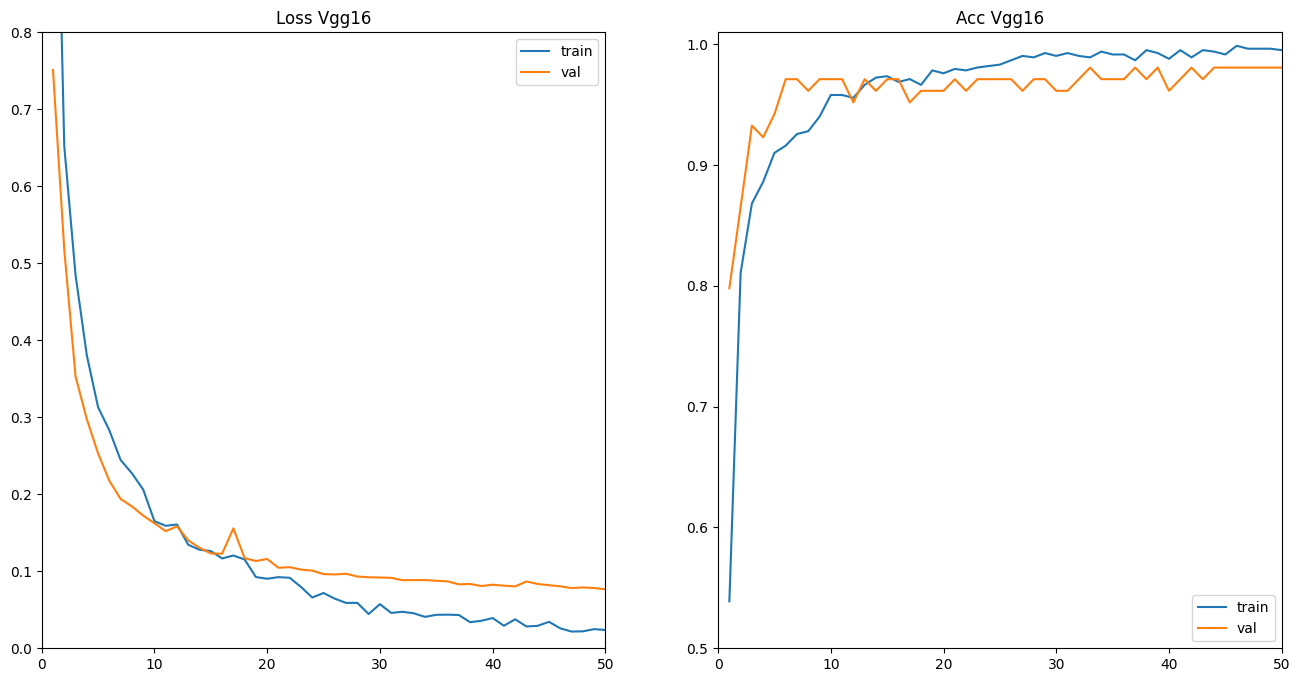

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))
plt.subplots_adjust(hspace=0.5)

axs = axs.ravel()
plt_lss("Loss Vgg16", model_vgg_info, axs[0], xlim_top=50, ylim_top=0.8)
plt_acc("Acc Vgg16", model_vgg_info, axs[1], xlim_top=50)

In [21]:
model_vgg.eval()
truel, predl = labels_and_predictions(dataloader_test, model_vgg, device)

In [22]:
vgg_acc = accuracy(truel, predl)
print("Accuracy VGG ", vgg_acc)
print(classification_report(truel, predl, target_names=class_labels))

Accuracy VGG  97.14285714285714
              precision    recall  f1-score   support

     blueTit       1.00      1.00      1.00        15
   chaffinch       1.00      1.00      1.00        15
     coalTit       0.83      1.00      0.91        15
   goldfinch       1.00      1.00      1.00        15
    greatTit       1.00      0.80      0.89        15
       robin       1.00      1.00      1.00        15
    starling       1.00      1.00      1.00        15

    accuracy                           0.97       105
   macro avg       0.98      0.97      0.97       105
weighted avg       0.98      0.97      0.97       105



In [ ]:
1e-3

0.001

# Run ResNet50

In [30]:
model_res = load_and_prep_resnet50()
optimizer = torch.optim.SGD(model_res.parameters(), lr=1e-3)

In [31]:
model_res, model_res_info = train_model(model_res, optimizer, num_epoch=100, train=dataloader_train, validation=dataloader_validation)

Epoch 1/100
----------
Train Loss: 1.9234 Acc: 0.2084
Val Loss: 1.8966 Acc: 0.2692
Epoch time 0m 4s
----------

Epoch 2/100
----------
Train Loss: 1.8877 Acc: 0.3162
Val Loss: 1.8563 Acc: 0.3365
Epoch time 0m 4s
----------

Epoch 3/100
----------
Train Loss: 1.8508 Acc: 0.4395
Val Loss: 1.8217 Acc: 0.5000
Epoch time 0m 4s
----------

Epoch 4/100
----------
Train Loss: 1.8162 Acc: 0.5461
Val Loss: 1.7855 Acc: 0.5769
Epoch time 0m 4s
----------

Epoch 5/100
----------
Train Loss: 1.7822 Acc: 0.6180
Val Loss: 1.7514 Acc: 0.6827
Epoch time 0m 4s
----------

Epoch 6/100
----------
Train Loss: 1.7455 Acc: 0.6886
Val Loss: 1.7211 Acc: 0.7212
Epoch time 0m 4s
----------

Epoch 7/100
----------
Train Loss: 1.7187 Acc: 0.7269
Val Loss: 1.6917 Acc: 0.7500
Epoch time 0m 4s
----------

Epoch 8/100
----------
Train Loss: 1.6843 Acc: 0.7713
Val Loss: 1.6582 Acc: 0.8077
Epoch time 0m 4s
----------

Epoch 9/100
----------
Train Loss: 1.6498 Acc: 0.8072
Val Loss: 1.6305 Acc: 0.8173
Epoch time 0m 4s
----

In [32]:
print_stats(model_res_info)

Lowest loss was 0.5992 at epoch 100
Highest accuracy was 0.9615 at epoch 86
Number of epochs run  100
Batch size was  16


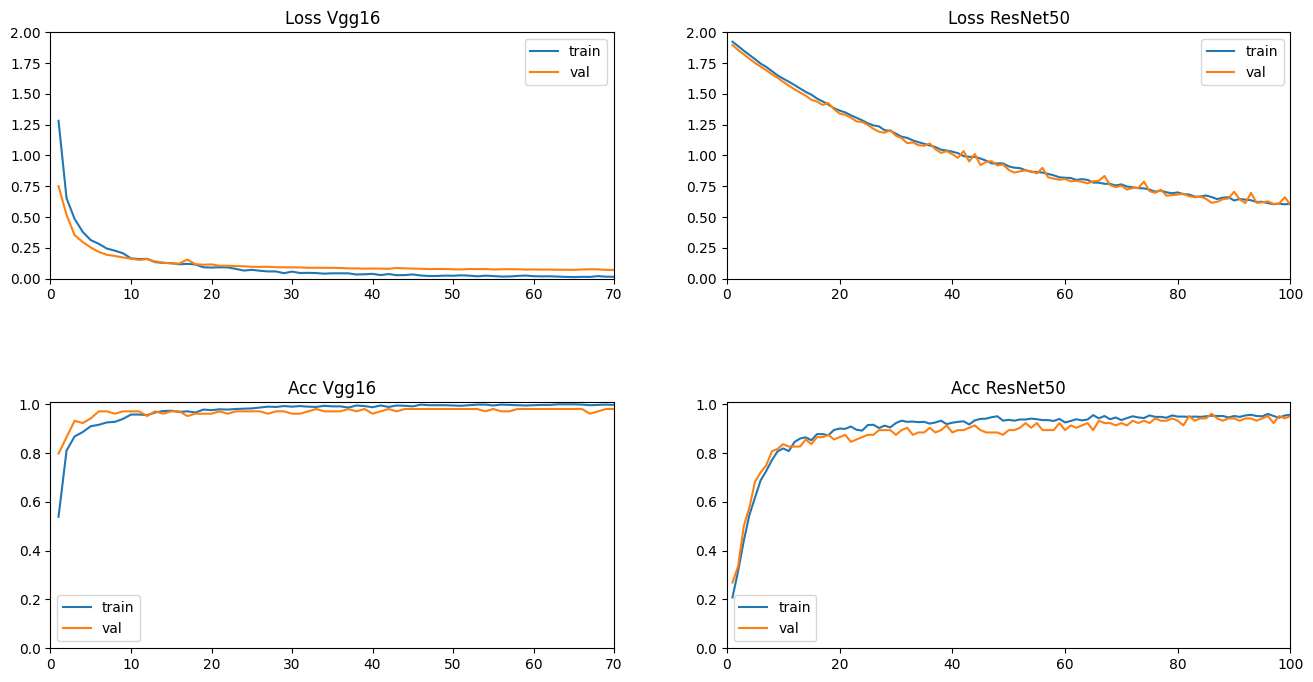

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(16,8))
plt.subplots_adjust(hspace=0.5)

axs = axs.ravel()
plt_lss("Loss Vgg16", model_vgg_info, axs[0], xlim_top=70, ylim_top=2)
plt_lss("Loss ResNet50", model_res_info, axs[1], xlim_top=100, ylim_top=2)
plt_acc("Acc Vgg16", model_vgg_info, axs[2], xlim_top=70, ylim_bot=0)
plt_acc("Acc ResNet50", model_res_info, axs[3], xlim_top=100, ylim_bot=0)

In [28]:
truel_res, predl_res = labels_and_predictions(dataloader_test,model_res,device )

In [29]:
res_acc = accuracy(truel_res, predl_res)
print(res_acc)
print(classification_report(truel_res, predl_res, target_names=class_labels))

95.23809523809523
              precision    recall  f1-score   support

     blueTit       1.00      1.00      1.00        15
   chaffinch       0.94      1.00      0.97        15
     coalTit       0.83      1.00      0.91        15
   goldfinch       0.94      1.00      0.97        15
    greatTit       1.00      0.73      0.85        15
       robin       1.00      0.93      0.97        15
    starling       1.00      1.00      1.00        15

    accuracy                           0.95       105
   macro avg       0.96      0.95      0.95       105
weighted avg       0.96      0.95      0.95       105



## Runs ResNet with momentum

In [34]:
model_res_momentum = load_and_prep_resnet50()
optimizer = torch.optim.SGD(model_res_momentum.parameters(), lr=1e-3, momentum=0.9)

In [35]:
model_res_mom, model_res_mom_info = train_model(model_res_momentum, optimizer, 100, dataloader_train, dataloader_validation)

Epoch 1/100
----------
Train Loss: 1.8386 Acc: 0.4000
Val Loss: 1.6483 Acc: 0.7692
Epoch time 0m 4s
----------

Epoch 2/100
----------
Train Loss: 1.5345 Acc: 0.8383
Val Loss: 1.3798 Acc: 0.8846
Epoch time 0m 4s
----------

Epoch 3/100
----------
Train Loss: 1.3120 Acc: 0.8778
Val Loss: 1.1752 Acc: 0.9038
Epoch time 0m 4s
----------

Epoch 4/100
----------
Train Loss: 1.1239 Acc: 0.8970
Val Loss: 1.0175 Acc: 0.9135
Epoch time 0m 3s
----------

Epoch 5/100
----------
Train Loss: 0.9880 Acc: 0.9222
Val Loss: 0.9228 Acc: 0.9135
Epoch time 0m 4s
----------

Epoch 6/100
----------
Train Loss: 0.8712 Acc: 0.9281
Val Loss: 0.8021 Acc: 0.9231
Epoch time 0m 4s
----------

Epoch 7/100
----------
Train Loss: 0.8006 Acc: 0.9377
Val Loss: 0.7493 Acc: 0.9327
Epoch time 0m 4s
----------

Epoch 8/100
----------
Train Loss: 0.7372 Acc: 0.9377
Val Loss: 0.7743 Acc: 0.9231
Epoch time 0m 4s
----------

Epoch 9/100
----------
Train Loss: 0.6742 Acc: 0.9437
Val Loss: 0.6213 Acc: 0.9423
Epoch time 0m 4s
----

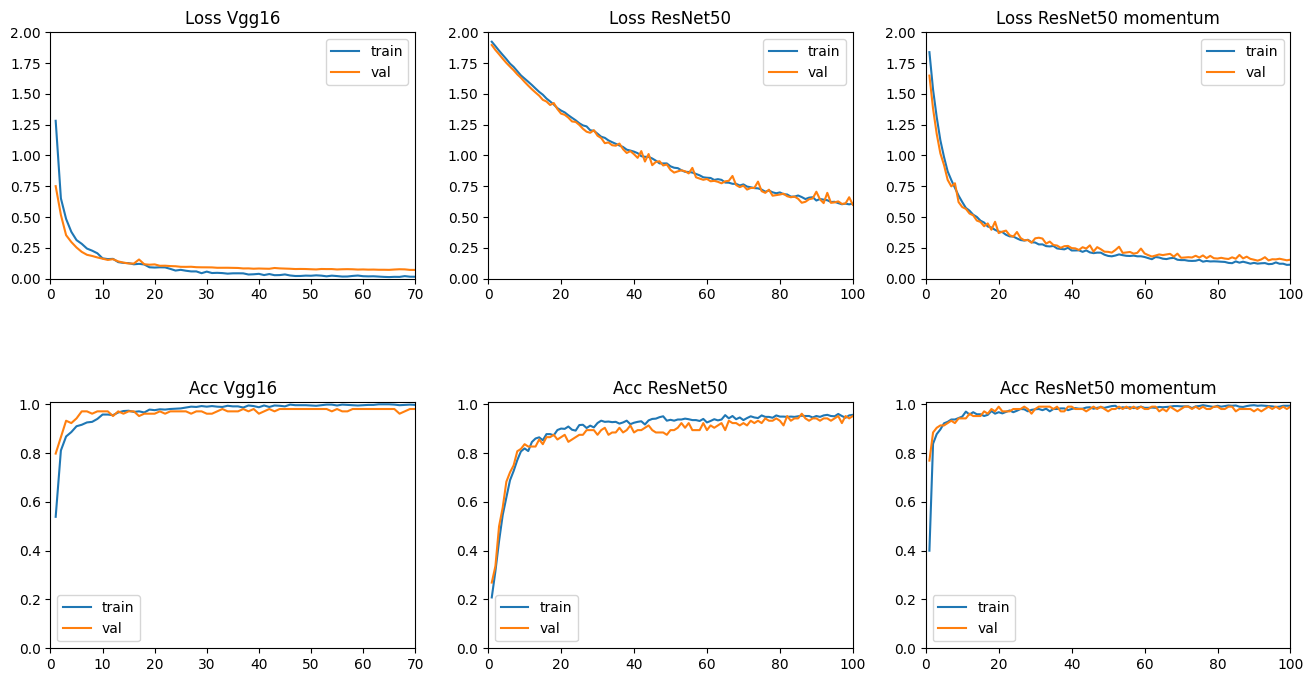

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
plt.subplots_adjust(hspace=0.5)

axs = axs.ravel()
plt_lss("Loss Vgg16", model_vgg_info, axs[0], xlim_top=70, ylim_top=2)
plt_lss("Loss ResNet50", model_res_info, axs[1], xlim_top=100, ylim_top=2)
plt_lss("Loss ResNet50 momentum", model_res_mom_info, axs[2], xlim_top=100, ylim_top=2)
plt_acc("Acc Vgg16", model_vgg_info, axs[3], xlim_top=70, ylim_bot=0)
plt_acc("Acc ResNet50", model_res_info, axs[4], xlim_top=100, ylim_bot=0)
plt_acc("Acc ResNet50 momentum", model_res_mom_info, axs[5], xlim_top=100, ylim_bot=0)

In [38]:
truel_mom, predl_mom = labels_and_predictions(dataloader_test, model_res_momentum, device)

In [39]:
mom_acc = accuracy(truel_mom, predl_mom)

In [40]:
print(mom_acc)

97.14285714285714
